(160000,)
(1, 1536)
(1, 16, 4, 1536)
(1, 14795)


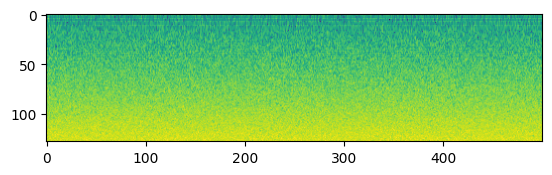

In [22]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf

tf.experimental.numpy.experimental_enable_numpy_behavior()

# Load the model.
model = hub.load(
    "https://www.kaggle.com/models/google/bird-vocalization-classifier/tensorFlow2/perch_v2/2"
)

# Input: 5 seconds of silence as mono 32 kHz waveform samples.
waveform = np.random.uniform(-1, 1, 5 * 32000).astype(np.float32)
print(waveform.shape)

# Run the model, check the output.
model_outputs = model.signatures["serving_default"](inputs=waveform[np.newaxis, :])

# Examine the spectrogram.
plt.imshow(model_outputs["spectrogram"][0].T)

# Examine the embeddings.
print(model_outputs["embedding"].shape)
print(model_outputs["spatial_embedding"].shape)

# Examine the logits.
print(model_outputs["label"].shape)

In [3]:
# get min, max, mean, std of logits
print(tf.reduce_min(model_outputs["label"]))
print(tf.reduce_max(model_outputs["label"]))
print(tf.reduce_mean(model_outputs["label"]))
print(tf.math.reduce_std(model_outputs["label"]))

tf.Tensor(-9.122648, shape=(), dtype=float32)
tf.Tensor(6.518101, shape=(), dtype=float32)
tf.Tensor(-1.4911782, shape=(), dtype=float32)
tf.Tensor(1.993037, shape=(), dtype=float32)


In [13]:
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from birdset.datamodule.base_datamodule import DatasetConfig, BirdSetTransformsWrapper


dm = BirdSetDataModule(
    dataset=DatasetConfig(
        data_dir="/workspace/data_birdset",
        hf_path="DBD-research-group/BirdSet",
        hf_name="NBP",
        n_workers=3,
        val_split=0.0001,
        task="multilabel",
        classlimit=500,
        eventlimit=5,
        sample_rate=32_000,
    ),
    transforms=BirdSetTransformsWrapper(
        sample_rate=32_000,
        model_type="waveform",
    ),
)
dm.prepare_data()
dm.setup("test")

sampling: 100%|██████████| 51/51 [00:08<00:00,  5.84it/s]



One-hot-encoding train labels.:   0%|          | 0/76451 [00:00<?, ? examples/s]

/workspace/birdset/datamodule/base_datamodule.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)


One-hot-encoding test_5s labels.:   0%|          | 0/539 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/76443 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

In [14]:
# get sample from the test set
dm.test_dataset[0]["input_values"].shape

/workspace/birdset/datamodule/components/transforms.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float16)


torch.Size([1, 160000])

In [33]:
sample1 = dm.test_dataset[0]["input_values"]
sample1 = sample1.detach().squeeze(0).cpu().numpy()
sample1.shape
logits = model.signatures["serving_default"](inputs=sample1[np.newaxis, :])["label"]
print(logits.shape)

(1, 14795)


In [18]:
len(dm.test_dataset)

539

In [36]:
# iterate over the test set
import tqdm


logits = []
targets = []

for i in range(len(dm.test_dataset)):
    sample = dm.test_dataset[i]
    input_numpy = sample["input_values"].squeeze(0).cpu().numpy()
    output = model.signatures["serving_default"](inputs=input_numpy[np.newaxis, :])
    logits.append(output["label"].numpy())
    targets.append(sample["labels"].numpy())

/workspace/birdset/datamodule/components/transforms.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float16)


In [37]:
import torch


logits = torch.tensor(np.vstack(logits))
targets = torch.tensor(np.vstack(targets))

In [39]:
logits.shape, targets.shape

(torch.Size([539, 14795]), torch.Size([539, 51]))

In [42]:
import datasets
import pandas as pd


pretrain_classlabels = pd.read_csv(
    "/workspace/projects/uncertainbird/resources/perch_v2_ebird_classes.csv"
)
# Extract the 'ebird2021' column as a list
pretrain_classlabels = pretrain_classlabels["ebird2021"].tolist()

# Load dataset information
dataset_info = datasets.load_dataset_builder("DBD-research-group/BirdSet", "XCL").info
dataset_classlabels = dataset_info.features["ebird_code"].names

# Create the class mask
class_mask = [
    pretrain_classlabels.index(label)
    for label in dataset_classlabels
    if label in pretrain_classlabels
]
class_indices = [
    i for i, label in enumerate(dataset_classlabels) if label in pretrain_classlabels
]

# Log missing labels
missing_labels = [
    label for label in dataset_classlabels if label not in pretrain_classlabels
]
if missing_labels:
    print(f"Missing labels in pretrained model: {missing_labels}")

Missing labels in pretrained model: ['grskiw1', 'dusscr1', 'butpig1', 'cregui3', 'crebob2', 'chhpar3', 'rinphe1', 'rinphe2', 'shefra1', 'chnfra2', 'chnfra3', 'bawnig3', 'sptnig1', 'granig3', 'bronig1', 'bksnig1', 'monnig1', 'rufpot1', 'gerswi1', 'alpswi1', 'motswi2', 'antman2', 'amtsun3', 'amtsun2', 'amtsun4', 'boorat1', 'boorat2', 'rubrat1', 'brarub1', 'whtmog2', 'lotsab1', 'stream2', 'stream3', 'vichum', 'grfhum1', 'manhum1', 'bfgbir1', 'grygab1', 'wbgbir1', 'puctur2', 'ruwtur2', 'prrtur1', 'whctur1', 'viotur1', 'rostur1', 'karbus1', 'ruebus1', 'savbus1', 'bucbus1', 'recbus1', 'blabus3', 'whqbus1', 'whbcou3', 'lobcuc1', 'hobcuc1', 'blecuc1', 'rtbcuc1', 'shbcuc1', 'webcuc1', 'libcuc1', 'palcuc1', 'whckoe1', 'brucuc2', 'lemdov2', 'matdov1', 'eurcod2', 'spodov', 'laudov1', 'mantho1', 'wbgdov1', 'wtgdov1', 'frgdov1', 'scgdov1', 'whigrp1', 'yebfrd1', 'yebfrd2', 'spiimp2', 'mouimp1', 'wsfrai1', 'chfrai1', 'forrai1', 'virrai1', 'afrcra1', 'ocecra1', 'ruccra1', 'yebcra1', 'mappyt1', 'dowcra1

In [43]:
# use class mask on logits
full_logits = torch.full(
    (logits.shape[0], 9736),  # Assuming 9736 is the total number of classes
    0.0,
    device=logits.device,
    dtype=logits.dtype,
)
# Extract valid logits using indices from class_mask and directly place them
full_logits[:, class_indices] = logits[:, class_mask]
logits = full_logits
logits.shape

torch.Size([539, 9736])

In [44]:
# expand targets to 9736 classes
target_pretrain_classlabels = datasets.load_dataset_builder(
    "DBD-research-group/BirdSet", "XCL"
).info.features["ebird_code"]
target_dataset_classlabels = datasets.load_dataset_builder(
    "DBD-research-group/BirdSet", "NBP"
).info.features["ebird_code"]
target_mask = [
    target_pretrain_classlabels.names.index(i) for i in target_dataset_classlabels.names
]
full_targets = torch.zeros(
    (targets.shape[0], 9736),  # Assuming 9736 is the total number of classes
    device=targets.device,
    dtype=targets.dtype,
)
full_targets[:, target_mask] = targets
targets = full_targets
targets.shape

torch.Size([539, 9736])

In [46]:
from uncertainbird.utils.plotting import print_metrics

predictions = torch.softmax(logits, dim=1)
# cast targets to int
targets = targets.to(torch.int)

metrics = print_metrics(predictions, targets)

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.buc

Accuracy: tensor(0.9999)
cmAP: tensor(0.6543)
Precision: tensor(0.0044)
Recall: tensor(0.0010)
F1 Score: tensor(0.0015)
AUROC: tensor(0.0049)
ECE: tensor(0.0002)
ECE Weighted: tensor(0.0302)
ECE Top-3: tensor(0.0453)
ECE Top-5: tensor(0.0429)
ECE Top-10: tensor(0.0420)
ECE Top-21: tensor(0.0377)
Miscalibration Score (MCS): tensor(-0.0296)
ECE Under-confidence: tensor(0.0299)
ECE Over-confidence: tensor(0.0003)


<Axes: title={'center': 'Reliability Diagram'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

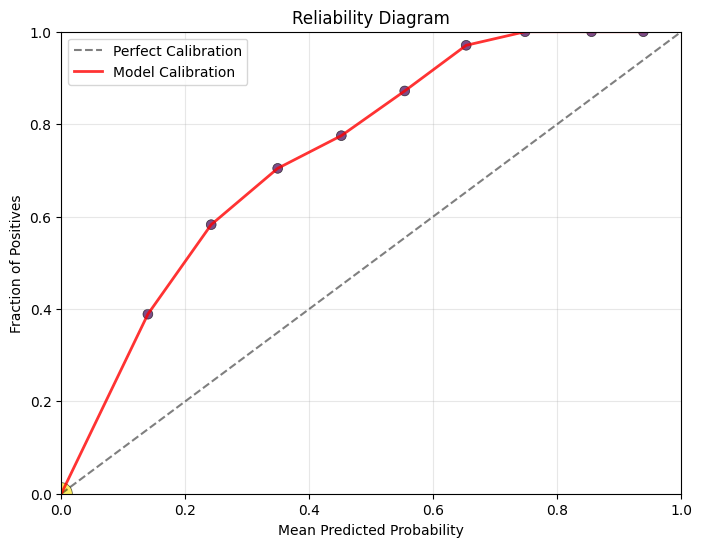

In [47]:
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(predictions, targets, n_bins=10)